In [1]:
import utils.modelling_lib_rodrixx as mod
import utils.preprocessing_lib_rodrixx as prep

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import os

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

import mlflow

In [2]:
dataframes_path = os.path.join(os.getcwd(), 'dataframes')
csv_path = os.path.join(os.getcwd(), 'column_csv')

In [3]:
df = pd.read_pickle(os.path.join(dataframes_path, 'stats_1982_to_2022.pkl'))

In [4]:
df.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP_pg,FG_pg,FGA_pg,...,DBPM_rank,BPM_rank,VORP_rank,%W,GT,%W_rank,%G,Votes,Share,MaxVotes
0,1,Kareem Abdul-Jabbar,C,34,LAL,76,76,35.2,9.9,17.1,...,20,5,8,0.695,82,3,0.927,31,0.045,690
1,2,Alvan Adams,C,27,PHO,79,75,30.3,6.4,13.0,...,10,13,15,0.561,82,10,0.963,0,0.000,690
2,3,Mark Aguirre,SF,22,DAL,51,20,28.8,7.5,16.1,...,48,34,36,0.341,82,36,0.622,0,0.000,690
3,4,Danny Ainge,SG,22,BOS,53,1,10.6,1.5,4.2,...,22,68,47,0.768,82,1,0.646,0,0.000,690
4,5,Tiny Archibald,PG,33,BOS,68,51,31.9,4.5,9.6,...,45,40,35,0.768,82,1,0.829,0,0.000,690


In [5]:
cols_tot = [col for col in df.columns if '_tot' in col]
cols_to_drop = ['Rk', 'G', 'GS', 'GT', 'Votes', 'MaxVotes', 'Tm']
cols_to_drop += cols_tot
cols_to_filter = ['PER', 'WS/48', 'BPM', 'USG%']
col_to_ohe = 'Pos'

In [6]:
pipe_clean = Pipeline(steps = [
    ('DropPlayersMultiTeams', prep.DropPlayersMultiTeams()),
    ('OutlierFilter', prep.OutlierFilter(q = .0005, col_to_filter = cols_to_filter)),
    ('SetIndex', prep.SetIndex()),
    ('OHE', prep.OHE(col_to_ohe)),
    ('DropColumns', prep.DropColumns(cols_to_drop)),
    ('DropPlayers', prep.DropPlayers()),
])

In [7]:
df = pipe_clean.fit_transform(df)

In [8]:
df.head()

,,Age,MP_pg,FG_pg,FGA_pg,FG%,3P_pg,3PA_pg,3P%,2P_pg,2PA_pg,...,VORP_rank,%W,%W_rank,%G,Share,Pos_C,Pos_PF,Pos_PG,Pos_SF,Pos_SG
Rk,Season,,,,,,,,,,,,,,,,,,,,,
1,1982,34,35.2,9.9,17.1,0.579,0.0,0.0,0.000,9.9,17.1,...,8,0.695,3,0.927,0.045,1,0,0,0,0
2,1982,27,30.3,6.4,13.0,0.494,0.0,0.0,0.000,6.4,13.0,...,15,0.561,10,0.963,0.000,1,0,0,0,0
3,1982,22,28.8,7.5,16.1,0.465,0.5,1.4,0.352,7.0,14.7,...,36,0.341,36,0.622,0.000,0,0,0,1,0
4,1982,22,10.6,1.5,4.2,0.357,0.1,0.3,0.294,1.4,3.8,...,47,0.768,1,0.646,0.000,0,0,0,0,1
5,1982,33,31.9,4.5,9.6,0.472,0.1,0.2,0.375,4.4,9.4,...,35,0.768,1,0.829,0.000,0,0,1,0,0


In [9]:
len(df[df.index.get_level_values(1) > 2016]) / len(df)

0.18186460874992907

In [10]:
val_df = df[df.index.get_level_values(1) > 2016]
dev_df = df[df.index.get_level_values(1) <= 2016]

In [11]:
dev_df, sampling_ratio = mod.oversample(dev_df, os_param = 'ros', sampling_strategy = .4)

In [12]:
X_train = dev_df.drop('Share', axis=1)
y_train = dev_df[['Share']]

X_val = val_df.drop('Share', axis=1)
y_val = val_df[['Share']]

In [13]:
scaler = MinMaxScaler()
scaler.fit(pd.concat([X_train, X_val], ignore_index = True))

MinMaxScaler()

In [14]:
datasets = {'train': X_train, 'val': X_val}
real_targets = {'train': y_train, 'val': y_val}

In [15]:
# pipe_scale = Pipeline(steps = [
#     ('Scaler', scaler),
#     ('ArrayToDf', prep.ArrayToDataFrame(columns = X_train.columns))
# ])

In [16]:
# for key, dataset in datasets.items():
#     index_param = dataset.index
#     pipe_scale.set_params(**{'ArrayToDf__index': index_param})
#     datasets[key] = pipe_scale.transform(dataset)

In [17]:
mlflow.set_experiment('NBA MVP prediction Random Forest')

<Experiment: artifact_location='file:///C:/Users/marcr/OneDrive/Documents/Data%20Science/NBA%20Project/mlruns/4', experiment_id='4', lifecycle_stage='active', name='NBA MVP prediction Random Forest', tags={}>

In [27]:
param_grid = {
    'max_depth': [8], 
    'min_samples_split': [10],
    'max_features': [.5],
    'n_estimators': [230]
    }

In [28]:
with mlflow.start_run():
    estimator = RandomForestRegressor(random_state = 23)

    model = GridSearchCV(estimator, param_grid, scoring = ('neg_root_mean_squared_error', 'r2'), refit = 'neg_root_mean_squared_error', cv = 10, verbose = 2)

    model.fit(X_train, y_train)

    results = model.cv_results_

    cv_scores = mod.get_cv_scores(results)

    best_model, best_params, best_cv_score = mod.retrieve_best(model)

    predicted_targets = mod.predict_model(best_model, datasets)

    mod.log_sampling_ratio_mlflow(sampling_ratio)

    mod.log_params_mlflow_rf(best_params)

    mod.log_metrics_mlflow(real_targets, predicted_targets, cv_scores)

    mod.log_advanced_metrics_mlflow(real_targets['val'], predicted_targets['val'])

    mod.log_model_mlflow(best_model)

    mod.log_features_mlflow(X_train, csv_path)

    mod.log_important_features_mlflow(mod.display_feature_importances(best_model))

    mod.log_val_results_mlflow(*mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=230; total time= 1.1min
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=230; total time=  40.7s
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=230; total time=  39.7s
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=230; total time=  46.0s
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=230; total time=  39.7s
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=230; total time=  40.7s
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=230; total time=  41.0s
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=230; total time=  40.5s
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=230; total time=  45.3s
[CV] END max_depth=8, max_features=0.5, min_samp

2022/10/15 22:13:26 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\marcr\AppData\Local\Temp\tmppfhufket\model\model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.0.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback.


In [29]:
mod.display_metrics(real_targets, predicted_targets, cv_scores)

,Train,CV,Validation
RMSE,0.014449,0.015514,0.031175
R2,0.991436,0.978607,0.686673


In [30]:
contenders_df, no_contenders_df = mod.get_val_results(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list)

In [31]:
mod.display_val_results(contenders_df, no_contenders_df)

Contenders Results:


,,Player,Share,PredShare
Rk,Season,,,
458,2017,Russell Westbrook,0.879,0.347916
173,2017,James Harden,0.746,0.531879
261,2017,Kawhi Leonard,0.495,0.492240
221,2017,LeBron James,0.330,0.261092
425,2017,Isaiah Thomas,0.080,0.165122
98,2017,Stephen Curry,0.051,0.242071
16,2017,Giannis Antetokounmpo,0.007,0.102515
453,2017,John Wall,0.007,0.057683
100,2017,Anthony Davis,0.002,0.122540


,,Player,Share,PredShare
Rk,Season,,,
195,2018,James Harden,0.955,0.741430
249,2018,LeBron James,0.731,0.313541
122,2018,Anthony Davis,0.441,0.202037
298,2018,Damian Lillard,0.205,0.147451
508,2018,Russell Westbrook,0.075,0.178802
16,2018,Giannis Antetokounmpo,0.074,0.142768
143,2018,Kevin Durant,0.065,0.231025
130,2018,DeMar DeRozan,0.032,0.022103
7,2018,LaMarcus Aldridge,0.006,0.058217


,,Player,Share,PredShare
Rk,Season,,,
18,2019,Giannis Antetokounmpo,0.932,0.564734
207,2019,James Harden,0.768,0.523741
184,2019,Paul George,0.352,0.107214
270,2019,Nikola Jokić,0.210,0.130397
124,2019,Stephen Curry,0.173,0.176631
305,2019,Damian Lillard,0.068,0.150305
155,2019,Joel Embiid,0.049,0.086411
150,2019,Kevin Durant,0.025,0.195784
301,2019,Kawhi Leonard,0.013,0.219764


,,Player,Share,PredShare
Rk,Season,,,
13,2020,Giannis Antetokounmpo,0.952,0.590275
251,2020,LeBron James,0.746,0.401589
199,2020,James Harden,0.363,0.438066
134,2020,Luka Dončić,0.198,0.163415
294,2020,Kawhi Leonard,0.166,0.189128
123,2020,Anthony Davis,0.081,0.306453
396,2020,Chris Paul,0.026,0.012941
297,2020,Damian Lillard,0.023,0.182549
262,2020,Nikola Jokić,0.018,0.041491


,,Player,Share,PredShare
Rk,Season,,,
263,2021,Nikola Jokić,0.961,0.500507
146,2021,Joel Embiid,0.580,0.166223
116,2021,Stephen Curry,0.449,0.200937
12,2021,Giannis Antetokounmpo,0.345,0.304608
396,2021,Chris Paul,0.138,0.035841
130,2021,Luka Dončić,0.042,0.158783
297,2021,Damian Lillard,0.038,0.180899
421,2021,Julius Randle,0.020,0.024952
439,2021,Derrick Rose,0.010,0.000239


,,Player,Share,PredShare
Rk,Season,,,
290,2022,Nikola Jokić,0.875,0.450972
162,2022,Joel Embiid,0.706,0.285710
12,2022,Giannis Antetokounmpo,0.595,0.317818
59,2022,Devin Booker,0.216,0.082830
141,2022,Luka Dončić,0.146,0.262520
526,2022,Jayson Tatum,0.043,0.093643
390,2022,Ja Morant,0.010,0.210735
126,2022,Stephen Curry,0.004,0.052279
438,2022,Chris Paul,0.002,0.066646


No contenders results:


Player  Share  PredShare
Rk  Season                                    
1   2017        Álex Abrines    0.0   0.000235
    2018        Álex Abrines    0.0   0.000235
    2019        Álex Abrines    0.0   0.000235
    2020        Steven Adams    0.0   0.001338
    2021    Precious Achiuwa    0.0   0.000235
...                      ...    ...        ...
601 2022      Thaddeus Young    0.0   0.000235
602 2022          Trae Young    0.0   0.121557
603 2022      Omer Yurtseven    0.0   0.000235
604 2022         Cody Zeller    0.0   0.000235
605 2022         Ivica Zubac    0.0   0.000331

[3130 rows x 3 columns]

In [32]:
no_contenders_df[no_contenders_df['PredShare'] > 0.1]

,,Player,Share,PredShare
Rk,Season,,,
38,2021,Bradley Beal,0.0,0.101719
66,2017,Jimmy Butler,0.0,0.146635
126,2019,Anthony Davis,0.0,0.113272
140,2021,Kevin Durant,0.0,0.104996
151,2019,Trevon Duval,0.0,0.129418
156,2017,Rudy Gobert,0.0,0.208985
177,2020,Rudy Gobert,0.0,0.126645
195,2022,Rudy Gobert,0.0,0.172822
244,2021,Kyrie Irving,0.0,0.137719


<AxesSubplot:title={'center':'Most important features'}, xlabel='Feature', ylabel='Importance coefficient'>

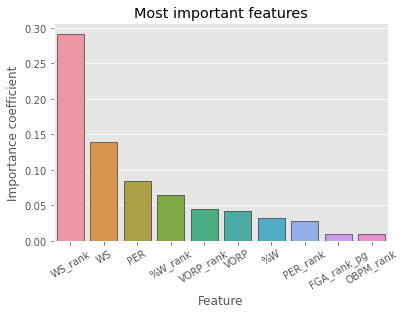

In [33]:
mod.display_feature_importances(best_model)

In [34]:
cont_df, no_cont_df = mod.get_val_results(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list)

(<Figure size 2880x2880 with 6 Axes>, <Figure size 2880x2880 with 6 Axes>)

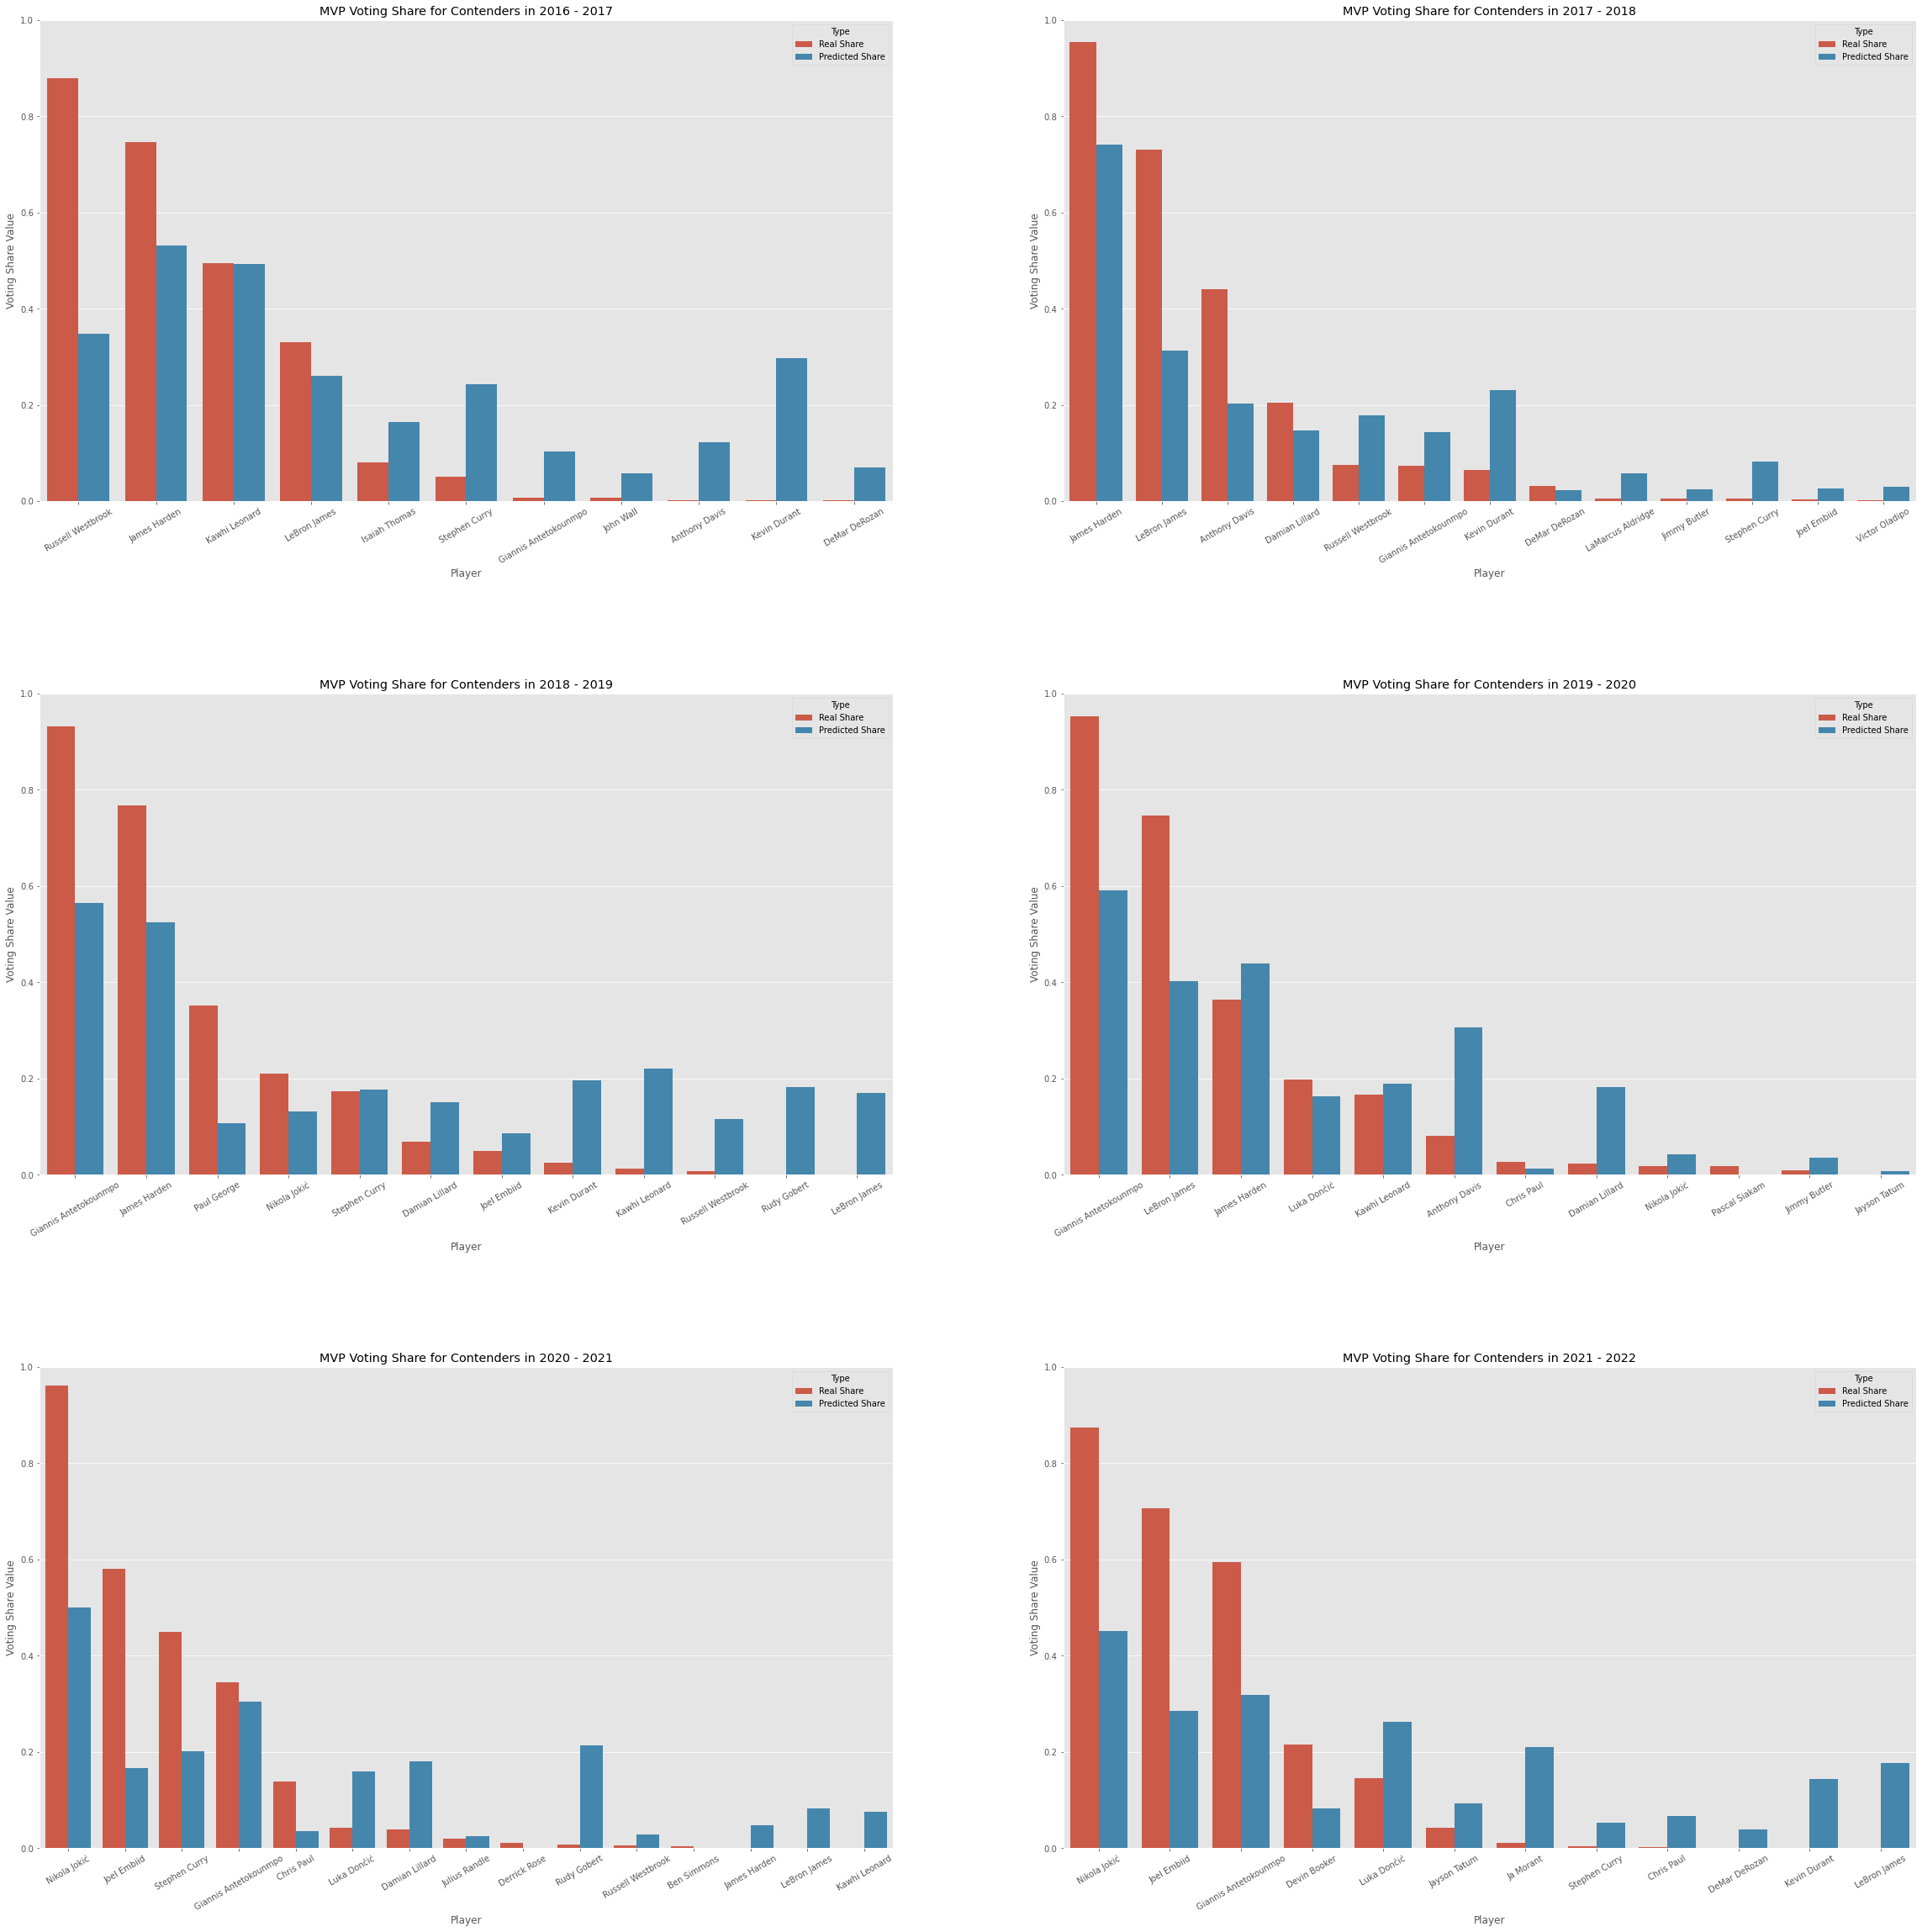

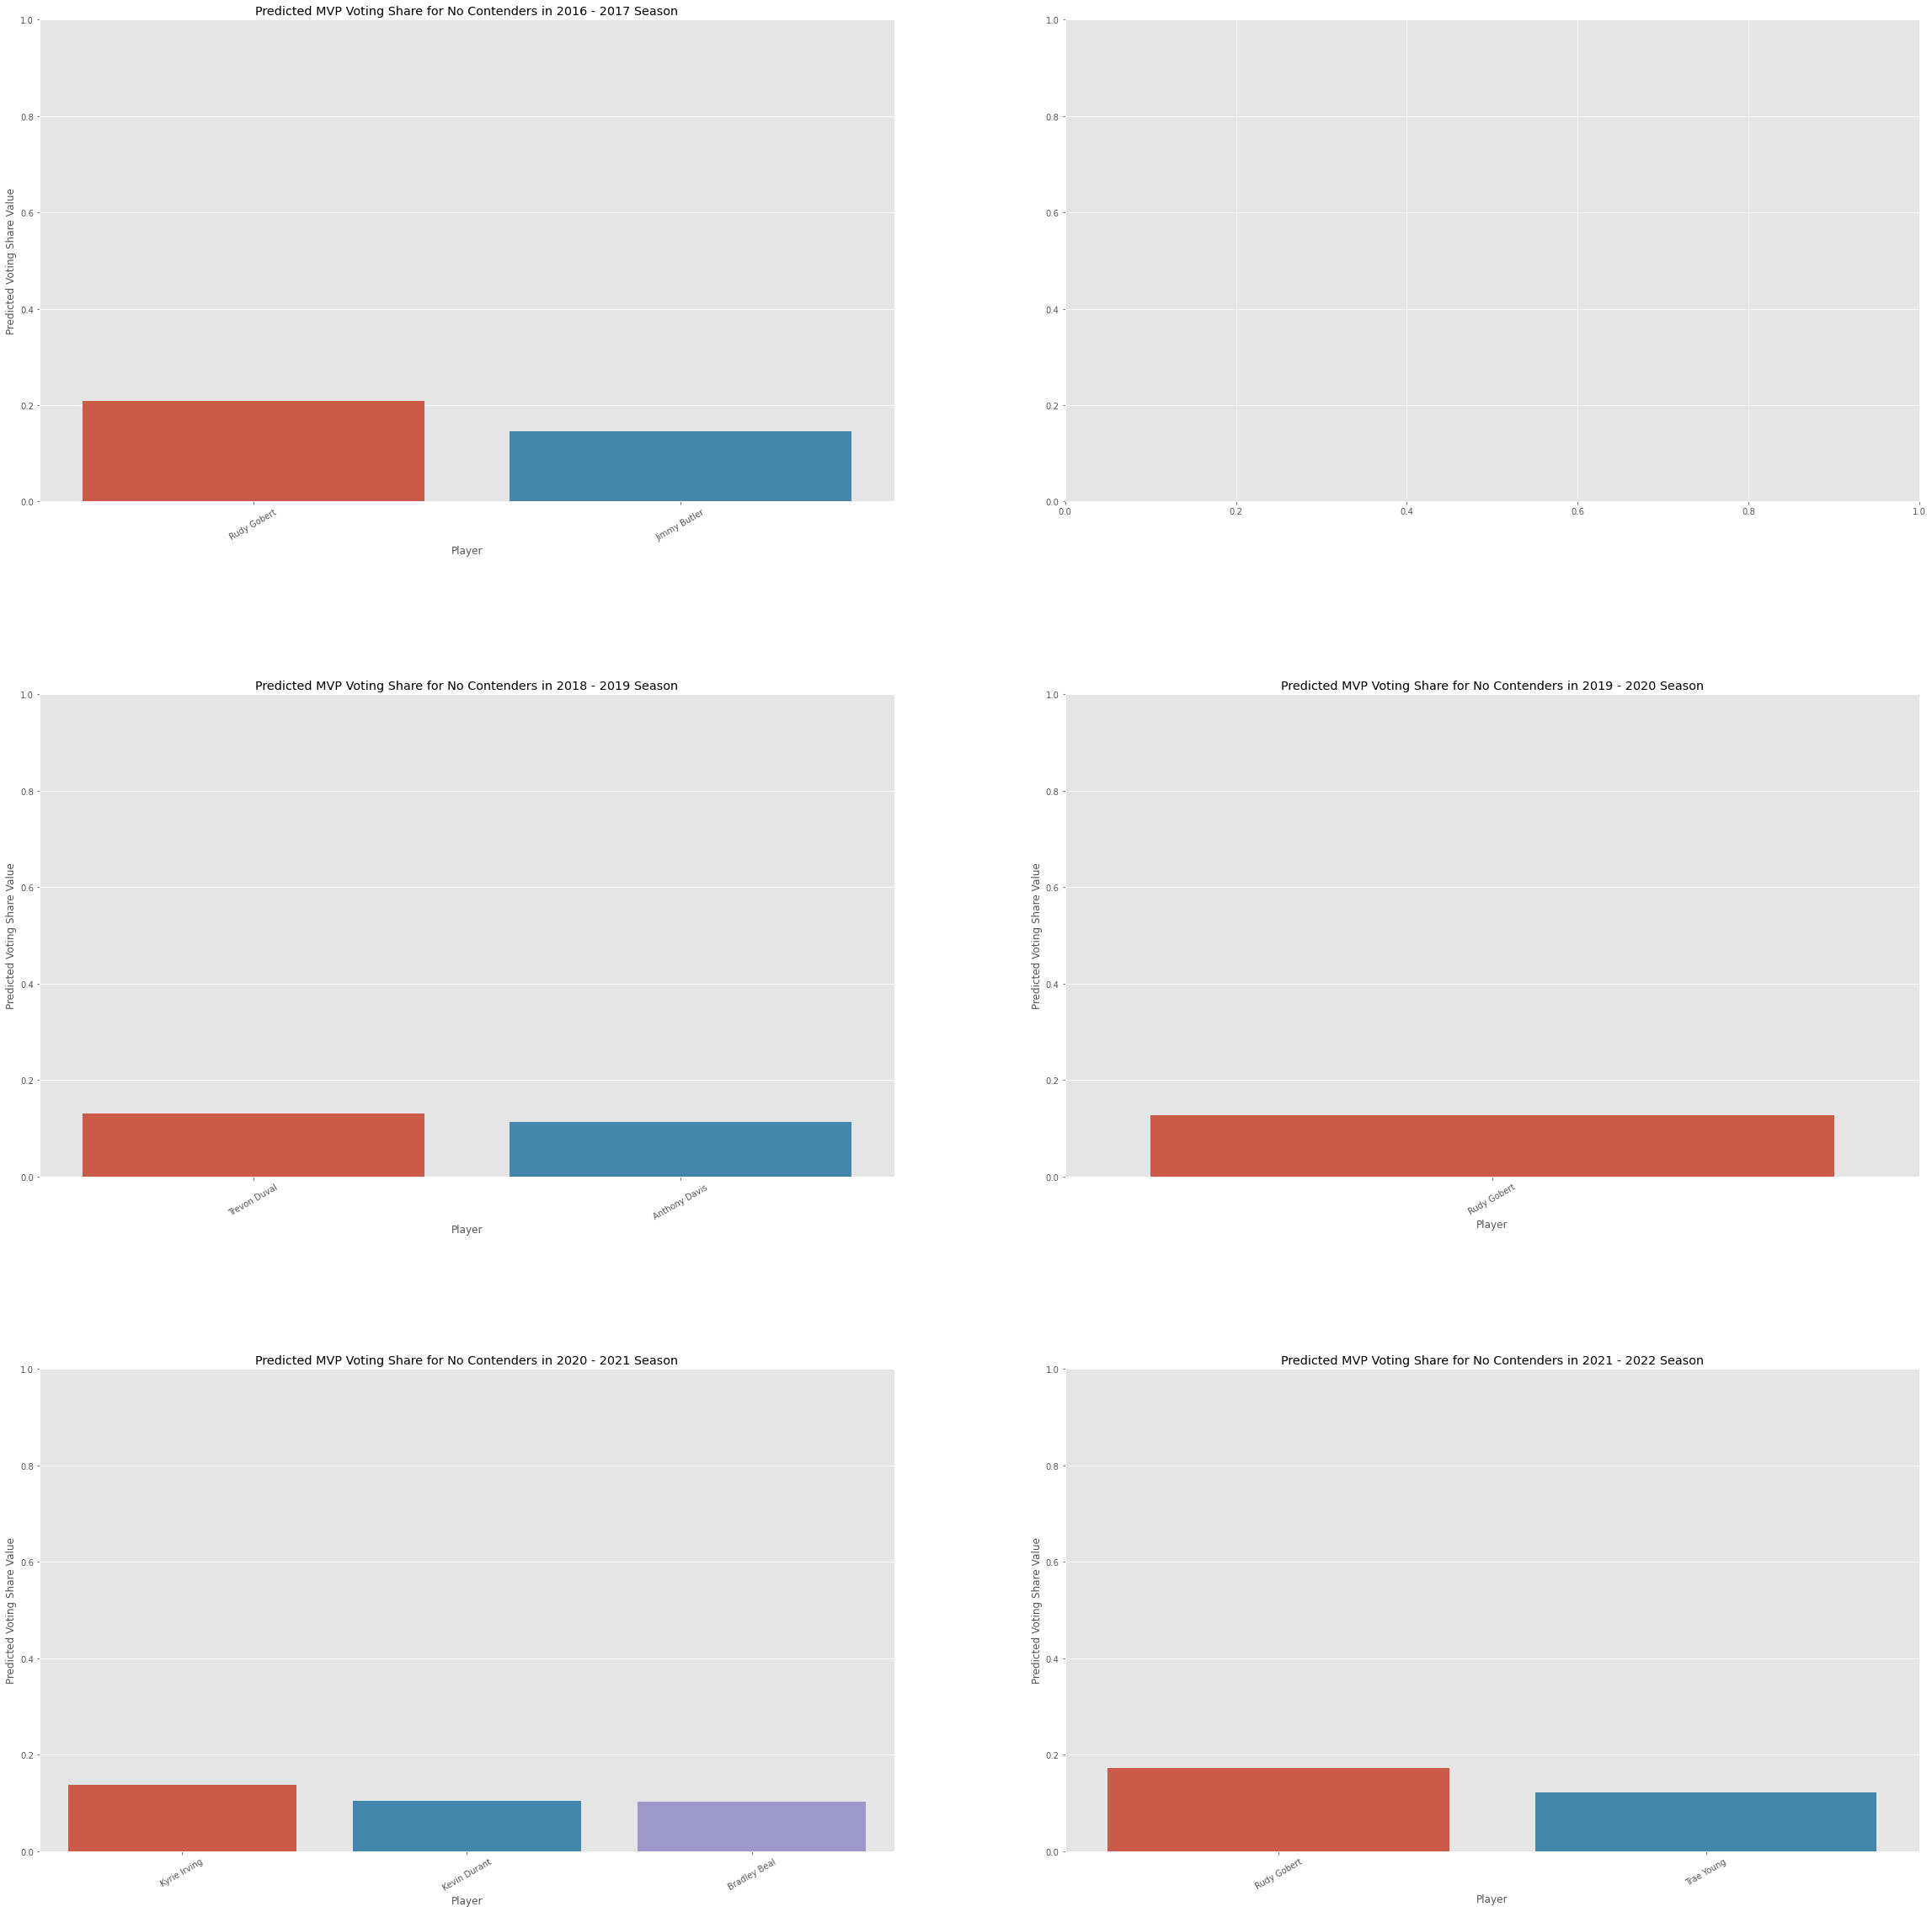

In [35]:
mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list)